In [ ]:
import pandas as pd
import geopandas as gpd
import pydeck as pdk
import matplotlib.pyplot as plt
import numpy as np
import folium

In [ ]:
rac = pd.read_csv("ca_rac_S000_JT00_2022.csv", dtype={"h_geocode": str})

In [ ]:
rac["tract"] = rac["h_geocode"].str[:11]

# Choose a data variable to plot

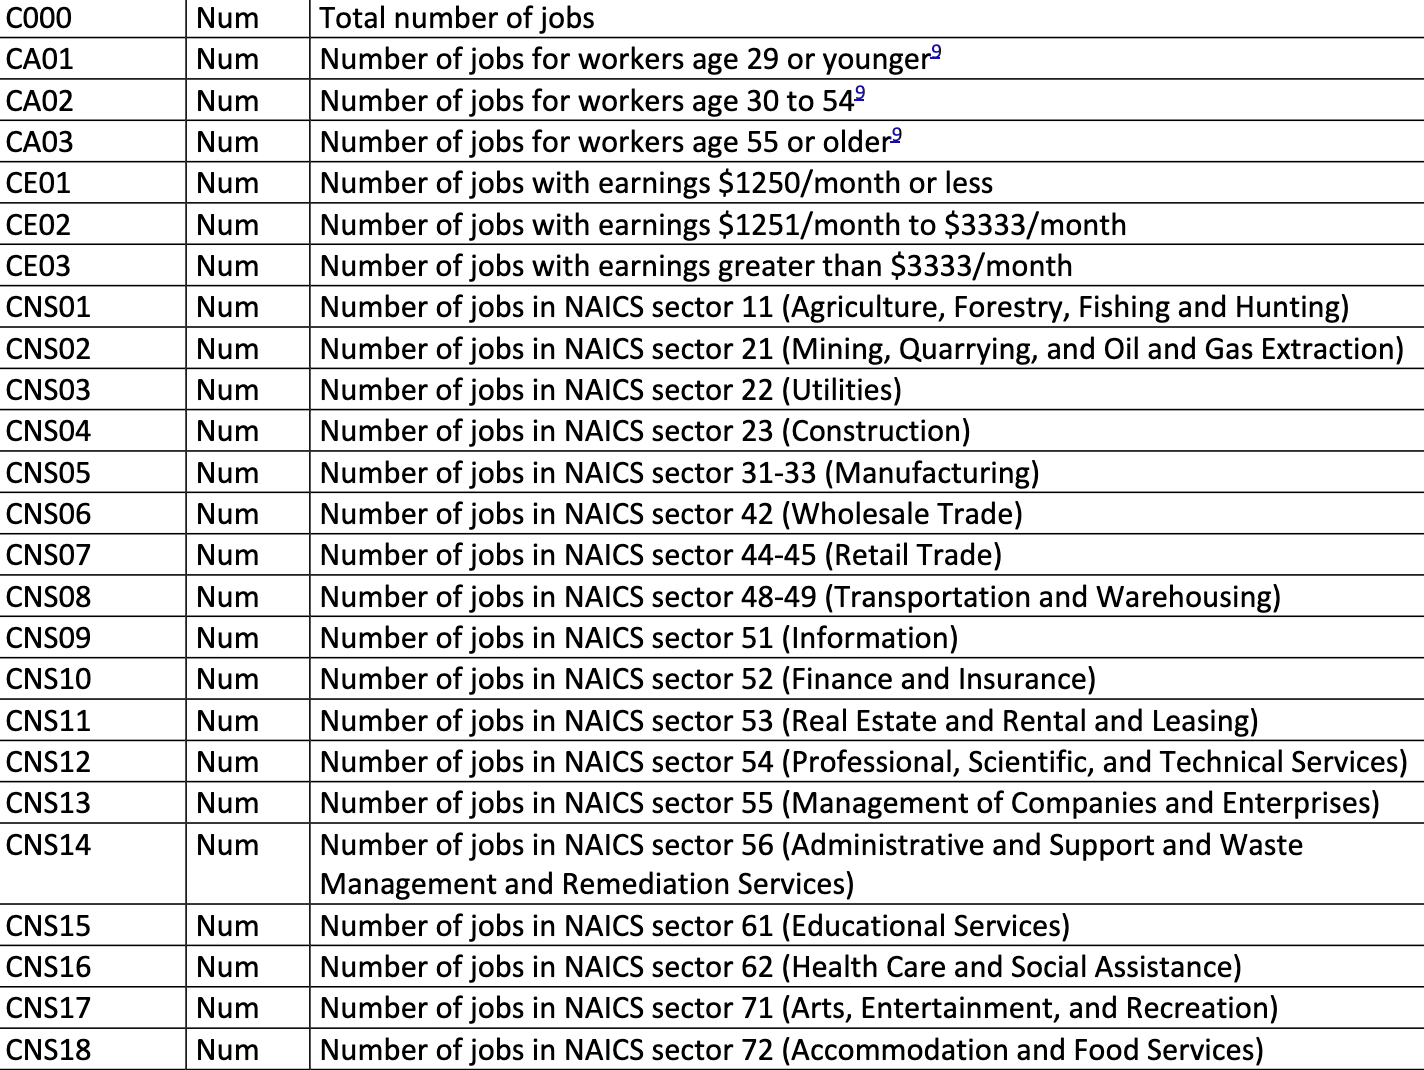

In [ ]:
data_var = "C000"

In [ ]:
# 3. Sum the worker counts by tract
workers_by_tract = (
    rac
    .groupby("tract", as_index=False)[data_var]
    .sum()
    .rename(columns={
        "tract": "GEOID",     # tract identifier
        data_var: "workers"     # total workers living in that tract
    })
)

In [ ]:
# ── 2. Load the California tract shapefile ──
# Make sure all .shp/.shx/.dbf files from tl_2022_06_tract.* are in the same folder.
path = "/Users/dsong/Library/CloudStorage/OneDrive-UniversityofIllinois-Urbana/Research/UROP 2025 - UAM/Demand Analysis/TIGER Line 2022 Tract/tl_2022_06_tract.shp"
tracts = gpd.read_file(path)[["GEOID", "geometry"]]

# ── 3. Merge worker counts onto the geometry ──
gdf = tracts.merge(workers_by_tract, on="GEOID", how="left").fillna(0)

# ── 4. Filter to the nine Bay-Area counties ──
bay_counties = {"06001","06013","06041","06055","06075","06081","06085","06095","06097"}
gdf_bay = gdf[gdf["GEOID"].str[:5].isin(bay_counties)].copy()

# ── 6. Plot the choropleth ──
fig, ax = plt.subplots(figsize=(10,10))
gdf_bay.plot(
    column="workers",      # the data field to visualize
    legend=True,           # show colorbar legend
    legend_kwds={
        "label": "Jobs",
        "fmt": "{:.0f}",
    },
    linewidth=0.1,         
    edgecolor="gray",
    ax=ax
)
ax.set_title(f"{data_var} Worker Population by Tract — Bay Area")
ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Define your view over the Bay Area
coords = np.vstack(gdf_bay.geometry.centroid.apply(lambda p: (p.y, p.x)))
view_state = pdk.ViewState(
    latitude=coords[:,0].mean(),
    longitude=coords[:,1].mean(),
    zoom=9,
    pitch=0
)

# 1. Center map on Bay Area
center = [view_state.latitude, view_state.longitude]
m = folium.Map(location=center, zoom_start=9, tiles=None)

# 2. Add Google Streets as your basemap
folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}",
    attr="Google",
    name="Google Streets",
    control=False
).add_to(m)

# 3. Add the choropleth with legend
folium.Choropleth(
    geo_data=gdf_bay.__geo_interface__,
    data=gdf_bay,
    columns=["GEOID","workers"],
    key_on="feature.properties.GEOID",
    fill_color="YlOrBr",         # pick any Matplotlib colormap
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name=f"Annual Commute Origins {data_var}"
).add_to(m)

# 4. Display
m